# Finetuning

This tutorial illustrates how to fine-tune the `GR00T-N1` pretrained checkpoint on a post-training 
dataset using the same embodiment. This showcases the benefit of post-training, transforming a generalist model into a specialist and demonstrating a performance gain.

For this tutorial, we will use the demo dataset `robot_sim.PickNPlace` from the [demo_data](./demo_data) folder. 

We will first load the pre-trained model and evaluate it on the dataset. Then we will finetune the model on the dataset and evaluate the performance.

## Pre-trained Model

In [1]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import Gr00tPolicy
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotSingleDataset
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

warnings.simplefilter("ignore", category=FutureWarning)

/home/boris/anaconda3/envs/py310/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-03-20 20:34:10.012686: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-20 20:34:10.031757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 20:34:10.031781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factor

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in SiglipVisionModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in LlamaForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but 

Loading pretrained dual brain from /home/boris/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /home/boris/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Total number of DiT parameters:  537803776
Tune action head projector: True
Tune action head diffusion model: True


Some weights of the model checkpoint at /home/boris/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb were not used when initializing GR00T_N1: ['action_head.decode_layer.bias', 'action_head.decode_layer.weight']
- This IS expected if you are initializing GR00T_N1 from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GR00T_N1 from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Tune action head projector: True
Tune action head diffusion model: True


The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Initialized dataset robot_sim.PickNPlace with EmbodimentTag.GR1
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 2.7079154301031316


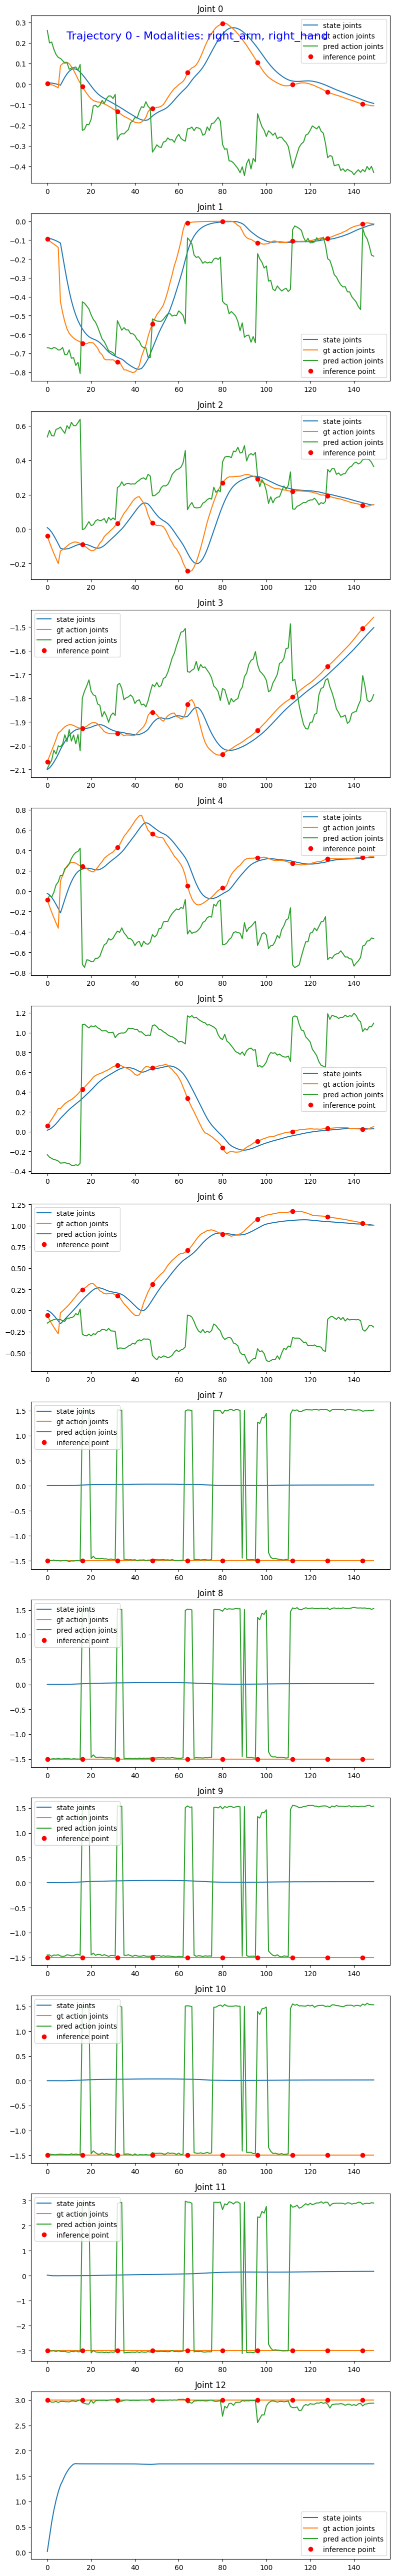

MSE loss for trajectory 0: 2.7079154301031316


In [2]:
PRE_TRAINED_MODEL_PATH = "nvidia/GR00T-N1-2B"
EMBODIMENT_TAG = EmbodimentTag.GR1
DATASET_PATH = "../demo_data/robot_sim.PickNPlace"


data_config = DATA_CONFIG_MAP["gr1_arms_only"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()


pre_trained_policy = Gr00tPolicy(
    model_path=PRE_TRAINED_MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)


mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Great! we can see the predicted actions and the ground truth actions. The predicted actions are not perfect but they are close to the ground truth actions. That's show that the pretrained checkpoint is working well.

Now let's sample 10 random trajectories and calcuate the mean MSE to get a sense of more verbose results.

In [3]:
total_trajectories = len(dataset.trajectory_lengths)

print("Total trajectories:", total_trajectories)

sampled_trajectories = np.random.choice(total_trajectories, 10)
print("Sampled trajectories:", sampled_trajectories)

all_mses = []

for traj_id in sampled_trajectories:
    mse = calc_mse_for_single_trajectory(
        pre_trained_policy,
        dataset,
        traj_id=traj_id,
        modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
        steps=150,
        action_horizon=16,
        plot=False
    )
    print(f"Trajectory {traj_id} MSE: {mse:.4f}")
    
    all_mses.append(mse)

print("====================================")
print("Mean MSE:", np.mean(all_mses))
print("Std MSE:", np.std(all_mses))


Total trajectories: 5
Sampled trajectories: [4 2 2 0 1 0 3 3 2 3]
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 4.389838849863472
Trajectory 4 MSE: 4.3898
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 2.553579667274967
Trajectory 2 MSE: 2.5536
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unno

## Finetuning the Model

Now we will finetune the model on the dataset. Without going into the details of the finetuning process, we will use the `gr00t_finetune.py` script to finetune the model. You can run the following command to finetune the model. 

```bash
python scripts/gr00t_finetune.py --dataset-path ./demo_data/robot_sim.PickNPlace --num-gpus 1 --max-steps 500 --output-dir /tmp/gr00t-1/finetuned-model --data-config gr1_arms_only
```

_To get a full list of the available arguments, you can run `python scripts/gr00t_finetune.py --help`._

The script will save the finetuned model in the `/tmp/gr00t-1/finetuned-model` directory. We will load the finetuned model with `500` checkpoint steps.  

### Evaluation of the Fine-tuned Model

Now we can evaluate the fine-tuned model by running the policy on the dataset and see how well it performs. We will use a utility function to evaluate the policy on the dataset. This is similar to the previous tutorial in [1_pretrained_model.ipynb](1_pretrained_model.ipynb)

In [4]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "/tmp/gr00t-1/finetuned-model/checkpoint-500"
finetuned_policy = Gr00tPolicy(
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

Model not found or avail in the huggingface hub. Loading from local path: /tmp/gr00t-1/finetuned-model/checkpoint-500
Loading pretrained dual brain from /tmp/gr00t-1/finetuned-model/checkpoint-500
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action head DiT: True
Model not found or avail in the huggingface hub. Loading from local path: /tmp/gr00t-1/finetuned-model/checkpoint-500


OSError: Incorrect path_or_model_id: '/tmp/gr00t-1/finetuned-model/checkpoint-500'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

Yaay! We have finetuned the model and evaluated it on the dataset. We can see that the model has learned the task and is able to perform the task better than the pre-trained model.